In [5]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Subset
import random
import numpy as np
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
import pickle

In [6]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [7]:
def plot_weight_histograms(model, title):
    weights = []
    for module in model.modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            weights.append(module.weight.detach().cpu().numpy().flatten())
    plt.figure(figsize=(15, 8))
    for i, w in enumerate(weights[:11]):
        plt.subplot(5, 6, i + 1)
        plt.hist(w, bins=40, color='blue', alpha=0.7)
        plt.title(f"Layer {i+1}")
        plt.tight_layout()
    plt.suptitle(title, y=1)
    plt.show()

In [16]:
vgg11 = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg11.classifier[6] = torch.nn.Linear(4096, 100)
vgg11.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
vgg11.load_state_dict(torch.load('models/vgg11_cifar100_baseline_5e.pt', weights_only=True, map_location=device))
vgg11.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [17]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 128
NUM_WORKERS = 4

g = torch.Generator()
g.manual_seed(42)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
full_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
_, small_test_subset = random_split(full_test, [7500, 2500], generator=g)
train_subset, val_subset = random_split(full_train, [45000, 5000], generator=g)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform
full_test.transform = test_transform
small_test_subset.transform = test_transform

print("Training set size:", len(train_subset))
print("Validation set size:", len(val_subset))
print("Test Set Size:", len(full_test))
print("Small Test Size:", len(small_test_subset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_subset, shuffle=True)
val_loader = get_loader(val_subset, shuffle=False)
test_loader = get_loader(full_test, shuffle=False)
small_test_loader = get_loader(small_test_subset, shuffle=False)

Training set size: 45000
Validation set size: 5000
Test Set Size: 10000
Small Test Size: 2500


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            preds = torch.argmax(preds, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy

In [19]:
base_acc = evaluate(vgg11, small_test_loader, device)
print(f"Base Accuracy: {base_acc:.2f}%")

Base Accuracy: 70.64%


In [11]:
def prune_layer_unstructured_L2(model, target_layer, amount=0.3):
  if amount == 0:
    return model
  for name, module in model.named_modules():
      if name == target_layer and isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)) and amount > 0:
          with torch.no_grad():
              weights = module.weight.data
              num_params = weights.numel()
              num_prune = int(amount * num_params)
              if num_prune == 0:
                  continue

              # Compute L2 magnitude (same as abs for scalars)
              magnitudes = weights.abs().view(-1)
              threshold = torch.topk(magnitudes, num_prune, largest=False).values.max()

              # Zero out smallest weights
              mask = (magnitudes > threshold).float()
              module.weight.data = (weights.view(-1) * mask).view_as(weights)
          break
  return model


In [12]:
layer_names = []
for name, module in vgg11.named_modules():
    if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
        layer_names.append(name)


In [13]:
prune_amts = [10,20,30,40,50,60,70,80,90]
sensitivity_dict = {}
for layer in layer_names:
  print(f"Layer {layer}")
  for perc in prune_amts:
    vgg11_copy = copy.deepcopy(vgg11)
    vg11_pruned = prune_layer_unstructured_L2(vgg11_copy, layer, perc/100)
    acc = evaluate(vg11_pruned, small_test_loader, device)
    print(f"{perc}% pruning: {acc:.2f}% Accuracy")
    sensitivity_dict[(layer, perc)] = acc

Layer features.0
10% pruning: 70.60% Accuracy
20% pruning: 70.56% Accuracy
30% pruning: 70.12% Accuracy
40% pruning: 70.60% Accuracy
50% pruning: 68.60% Accuracy
60% pruning: 60.92% Accuracy
70% pruning: 52.12% Accuracy
80% pruning: 35.12% Accuracy
90% pruning: 24.32% Accuracy
Layer features.3
10% pruning: 70.60% Accuracy
20% pruning: 70.60% Accuracy
30% pruning: 70.40% Accuracy
40% pruning: 70.68% Accuracy
50% pruning: 70.80% Accuracy
60% pruning: 70.72% Accuracy
70% pruning: 70.76% Accuracy
80% pruning: 69.60% Accuracy
90% pruning: 65.68% Accuracy
Layer features.6
10% pruning: 70.64% Accuracy
20% pruning: 70.64% Accuracy
30% pruning: 70.72% Accuracy
40% pruning: 70.72% Accuracy
50% pruning: 70.80% Accuracy
60% pruning: 70.24% Accuracy
70% pruning: 70.72% Accuracy
80% pruning: 69.80% Accuracy
90% pruning: 67.64% Accuracy
Layer features.8
10% pruning: 70.64% Accuracy
20% pruning: 70.56% Accuracy
30% pruning: 70.60% Accuracy
40% pruning: 70.84% Accuracy
50% pruning: 70.72% Accuracy
60% 

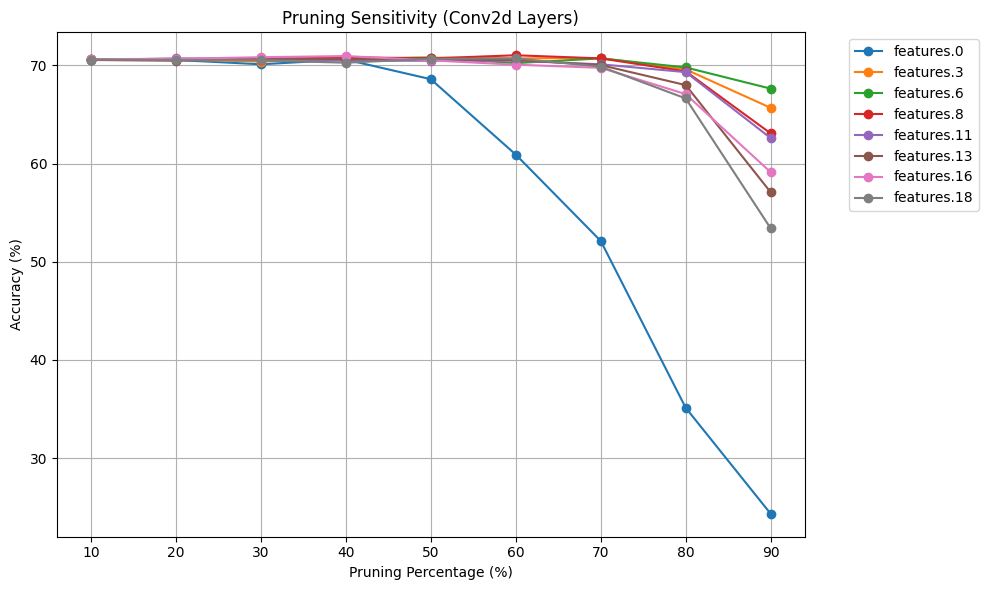

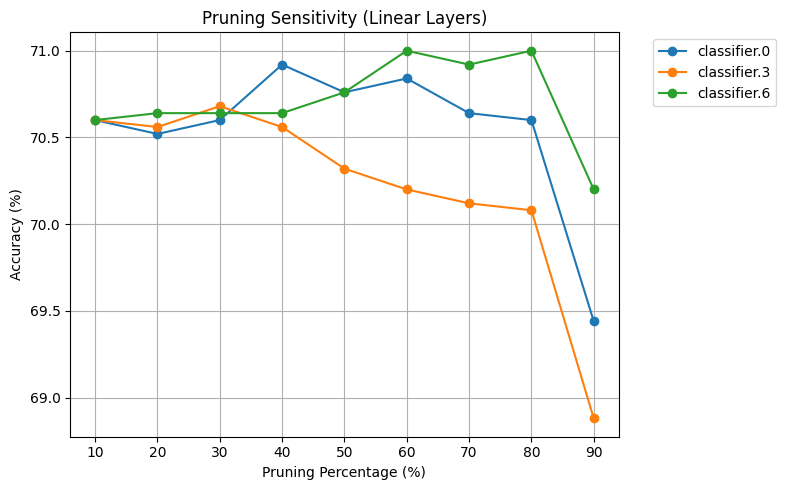

In [14]:
# Separate conv and linear layer names
conv_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Conv2d)]
linear_layers = [name for name, module in vgg11.named_modules() if isinstance(module, torch.nn.Linear)]

# --- Plot for Conv layers ---
plt.figure(figsize=(10, 6))
for layer in conv_layers:
    accs = [sensitivity_dict.get((layer, p), None) for p in prune_amts]
    plt.plot(prune_amts, accs, marker='o', label=layer)

plt.title("Pruning Sensitivity (Conv2d Layers)")
plt.xlabel("Pruning Percentage (%)")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot for Linear layers ---
plt.figure(figsize=(8, 5))
for layer in linear_layers:
    accs = [sensitivity_dict.get((layer, p), None) for p in prune_amts]
    plt.plot(prune_amts, accs, marker='o', label=layer)

plt.title("Pruning Sensitivity (Linear Layers)")
plt.xlabel("Pruning Percentage (%)")
plt.ylabel("Accuracy (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Save the dictionary to a file
with open('sensitivity_dict_unstructured.pkl', 'wb') as f:
    pickle.dump(sensitivity_dict, f)